In [34]:
import gymnasium as gym
import gym_anytrading
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO, DQN  # select model
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [35]:
data = pd.read_csv('dataset/AAPL.csv')
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data.sort_index(ascending=True, inplace=True)

data = data.head(102)

In [36]:
window_size = 50
start_index = window_size
end_index = len(data)


def create_env(data: pd.DataFrame, start_index: int, end_index: int, window_size: int):
    env = gym.make('stocks-v0', df=data, frame_bound=(start_index,
                   end_index), window_size=window_size)
    env.trade_fee = 0
    return env


def env_maker(data: pd.DataFrame, start_index: int, end_index: int, window_size: int):
    return create_env(data, start_index, end_index, window_size)

In [37]:
env = DummyVecEnv(
    [lambda: env_maker(data, start_index, end_index, window_size)])
model = PPO(MlpPolicy, env, verbose=1)

Using cuda device


In [38]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.00 +/- 0.00


In [43]:
model.learn(total_timesteps=100000)

Logging to ./tensorboard/PPO_6
-----------------------------
| time/              |      |
|    fps             | 919  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 698         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011277835 |
|    clip_fraction        | 0.0348      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.648      |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0077      |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.000962   |
|    value_loss           | 0.00457     |
-----------------------------------------
---

In [44]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.00 +/- 0.00


In [45]:
import os

# Create save dir
save_dir = "/tmp/gym/"
os.makedirs(save_dir, exist_ok=True)

model.save(f"{save_dir}/agentModel")

(50, 2)
info {'total_reward': 0.2559967041015625, 'total_profit': 0.8884109582550752, 'position': <Positions.Long: 1>}


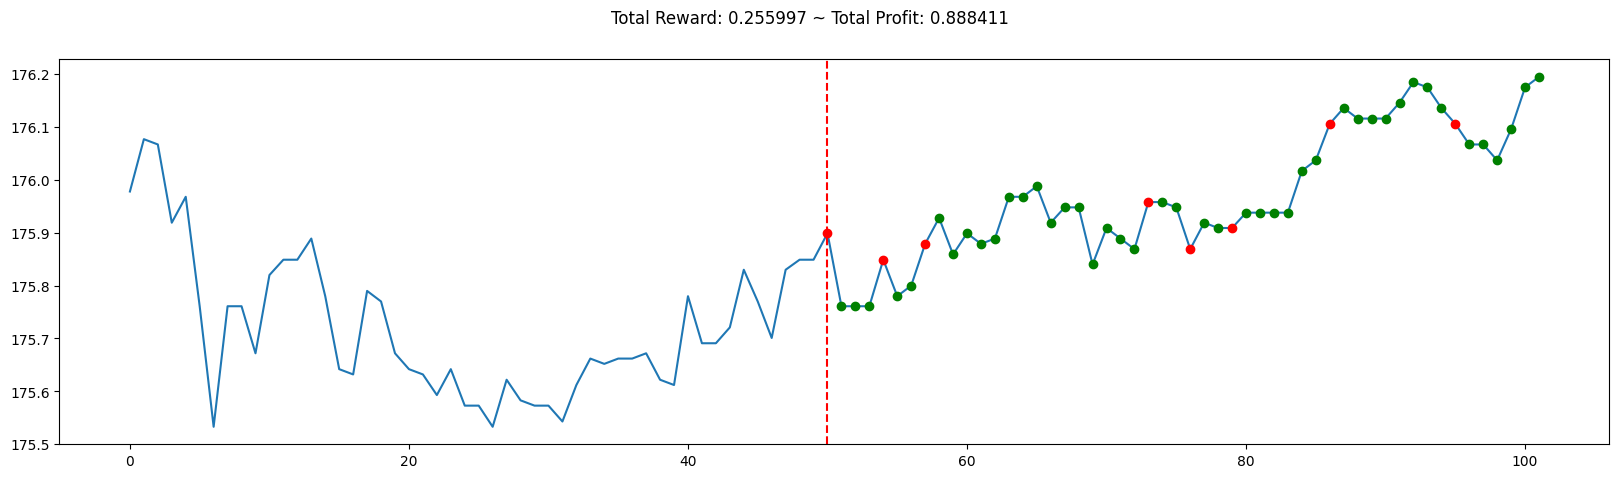

In [48]:
env = gym.make('stocks-v0', df=data, frame_bound=(start_index,
               end_index), window_size=window_size)
env.trade_fee = 0

obs, info = env.reset()

print(obs.shape)
while True:
    action, state = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        print("info", info)
        break

plt.figure(figsize=(20, 5))
env.render_all()
plt.axvline(x=window_size, color='r', linestyle='--')
plt.show()

# red = short
# green = long